# Numpy regression

### Goals: 
- Intro: train a logistic regression
- Diving deep: implement a real gradient descent in `Numpy`

### Dataset:
- Digits: 10 class handwritten digits
- http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits

In [1]:
%matplotlib inline 
# display figures in the notebook
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits

digits = load_digits()

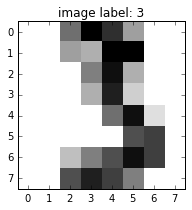

In [2]:
sample_index = 45
plt.figure(figsize=(3, 3))
plt.imshow(digits.images[sample_index], cmap=plt.cm.gray_r,
           interpolation='nearest')
plt.title("image label: %d" % digits.target[sample_index]);

### Preprocessing

- normalization
- train/test split

In [3]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.15, random_state=37)

# mean = 0 ; standard deviation = 1.0
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# print(scaler.mean_)
# print(scaler.scale_)

Let's display the one of the transformed sample (after feature standardization):

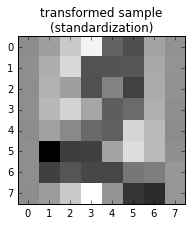

In [4]:
sample_index = 45
plt.figure(figsize=(3, 3))
plt.imshow(X_train[sample_index].reshape(8, 8),
           cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("transformed sample\n(standardization)");

The scaler objects makes it possible to recover the original sample:

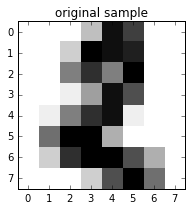

In [5]:
plt.figure(figsize=(3, 3))
plt.imshow(scaler.inverse_transform(X_train[sample_index]).reshape(8, 8),
           cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("original sample");

In [6]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1527, 64) (1527,)
(270, 64) (270,)


In [7]:
from keras.utils.np_utils import to_categorical

Y_train = to_categorical(y_train)

Using Theano backend.


# Numpy Implementation

##  Logistic Regression

We will implement a logistic regression model trainable with SGD using numpy. Here are the objectives:

1/ Implement a simple forward model with no hidden layer (equivalent to a logistic regression):
note: shape, transpose of W with regards to course
$y = softmax(\mathbf{W} \dot x + b)$

2/ build a predict function which returns the most probable class given an input $x$

3/ build an accuracy function for a batch of inputs $X$ and the corresponding expected outputs $y_{true}$

4/ build a grad function which computes $\frac{d}{dW} -\log(softmax(W \dot x + b))$ for an $x$ and its corresponding expected output $y_{true}$ ; check that the gradients are well defined

5/ build a train function which uses the grad function output to update $\mathbf{W}$ and $b$


First let's define a helper function to compute the one hot encoding of an integer array for a fixed number of classes (similar to keras' `to_categorical`):

In [8]:
def one_hot(n_classes, y):
    return np.eye(n_classes)[y]

In [9]:
one_hot(10, 3)

array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.])

In [10]:
one_hot(10, [0, 4, 9, 1])

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

Now let's implement the softmax vector function:

$$
softmax(\mathbf{x}) = \frac{1}{\sum_{i=1}^{n}{e^{x_i}}}
\cdot
\begin{bmatrix}
  e^{x_1}\\\\
  e^{x_2}\\\\
  \vdots\\\\
  e^{x_n}
\end{bmatrix}
$$

In [11]:
def softmax(X):
    # TODO:
    return None

Make sure that this works one vector at a time (and check that the components sum to one):

In [12]:
print(softmax([10, 2, -3]))

None


Note that a naive implementation of softmax might not be able process a batch of activations in a single call:

In [13]:
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

None


Here is a way to implement softmax that works both for an individal vector of activations and for a batch of activation vectors at once:

In [14]:
def softmax(X):
    exp = np.exp(X)
    return exp / np.sum(exp, axis=-1, keepdims=True)


print("softmax of a single vector:")
print(softmax([10, 2, -3]))
print(np.sum(softmax([10, 2, -3])))

softmax of a single vector:
[  9.99662391e-01   3.35349373e-04   2.25956630e-06]
1.0


In [15]:
print("sotfmax of 2 vectors:")
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))
print(np.sum(softmax(X), axis=1))

sotfmax of 2 vectors:
[[  9.99662391e-01   3.35349373e-04   2.25956630e-06]
 [  2.47262316e-03   9.97527377e-01   1.38536042e-11]]
[ 1.  1.]


Implement a function that given the true one-hot encoded class `Y_true` and and some predicted probabilities `Y_pred` returns the negative log likelihood.

In [16]:
def nll(Y_true, Y_pred):
    # TODO
    return 0.


# Make sure that it works for a simple sample at a time
print(nll([1, 0, 0], [.99, 0.01, 0]))

0.0


Check that the nll of a very confident yet bad prediction is a much higher positive number:

In [17]:
print(nll([1, 0, 0], [0.01, 0.01, .98]))

0.0


Make sure that your implementation can compute the average negative log likelihood of a group of predictions: `Y_pred` and `Y_true` can therefore be past as 2D arrays:

In [18]:
def nll(Y_true, Y_pred):
    Y_true, Y_pred = np.atleast_2d(Y_true), np.atleast_2d(Y_pred)
    # TODO
    return 0.

In [19]:
# Check that the average NLL of the following 3 almost perfect
# predictions is close to 0
Y_true = np.array([[0, 1, 0],
                   [1, 0, 0],
                   [0, 0, 1]])

Y_pred = np.array([[0,   1,    0],
                   [.99, 0.01, 0],
                   [0,   0,    1]])

print(nll(Y_true, Y_pred))

0.0


In [20]:
EPSILON = 1e-8

def nll(Y_true, Y_pred):
    Y_true, Y_pred = np.atleast_2d(Y_true), np.atleast_2d(Y_pred)
    loglikelihoods = np.sum(np.log(EPSILON + Y_pred) * Y_true, axis=1)
    return -np.mean(loglikelihoods)


# Make sure that it works for a simple sample at a time
print(nll([1, 0, 0], [.99, 0.01, 0]))

# Check that the nll of a very confident yet bad prediction
# is very high:
print(nll([1, 0, 0], [0.01, 0.01, .98]))

# Check that the average NLL of the following 3 almost perfect
# predictions is close to 0
Y_true = np.array([[0, 1, 0],
                   [1, 0, 0],
                   [0, 0, 1]])

Y_pred = np.array([[0,   1,    0],
                   [.99, 0.01, 0],
                   [0,   0,    1]])
print(nll(Y_true, Y_pred))

0.0100503257525
4.60516918599
0.0033501019175


Let us now study the following linear model trainable by SGD, **one sample at a time**.

In [21]:
class LogisticRegression():

    def __init__(self, input_size, output_size):
        # TO DO, initialize randomly W and b
        self.W = None
        self.b = None
        self.output_size = output_size
        
    def forward(self, X):
        # TO DO
        Z = None
        return None
    
    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)
    
    def grad_loss(self, x, y_true):
        y_pred = self.forward(x)
        # TO DO
        dnll_output =  None
        grad_W = None
        grad_b = None
        grads = {"W": grad_W, "b": grad_b}
        return grads
    
    def train(self, x, y, learning_rate):
        # Traditional SGD update without momentum
        grads = self.grad_loss(x, y)
        # TO DO
        self.W = None
        self.b = None
        
    def loss(self, x, y):
        #TO DO
        return None

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

In [22]:
class LogisticRegression():

    def __init__(self, input_size, output_size):
        self.W = np.random.uniform(size=(input_size, output_size),
                                   high=0.1, low=-0.1)
        self.b = np.random.uniform(size=output_size,
                                   high=0.1, low=-0.1)
        self.output_size = output_size
        
    def forward(self, X):
        Z = np.dot(X, self.W) + self.b
        return softmax(Z)
    
    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)
    
    def grad_loss(self, x, y_true):
        y_pred = self.forward(x)
        dnll_output =  y_pred - one_hot(self.output_size, y_true)
        grad_W = np.outer(x, dnll_output)
        grad_b = dnll_output
        grads = {"W": grad_W, "b": grad_b}
        return grads
    
    def train(self, x, y, learning_rate):
        # Traditional SGD update without momentum
        grads = self.grad_loss(x, y)
        self.W = self.W - learning_rate * grads["W"]
        self.b = self.b - learning_rate * grads["b"]      
        
    def loss(self, x, y):
        return nll(one_hot(self.output_size, y), self.forward(x))

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

In [23]:
# Build a model and test its forward inference
n_features = X_train.shape[1]
n_classes = Y_train.shape[1]
lr = LogisticRegression(n_features, n_classes)

print("Evaluation of the untrained model:")
train_loss = lr.loss(X_train, y_train)
train_acc = lr.accuracy(X_train, y_train)
test_acc = lr.accuracy(X_train, y_train)

print("train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
      % (train_loss, train_acc, test_acc))

Evaluation of the untrained model:
train loss: 2.2978, train acc: 0.114, test acc: 0.114


3


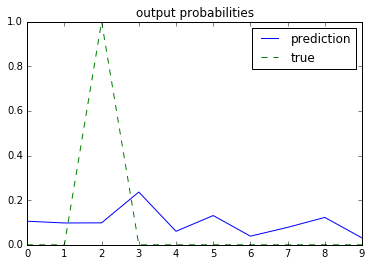

In [24]:
# Test the untrained model on the first example
sample_idx = 0
plt.plot(lr.forward(X_train[sample_idx]), linestyle='-', label='prediction')
plt.plot(one_hot(10, y_train[sample_idx]), linestyle='--', label='true')
plt.title('output probabilities')
plt.legend()
print(lr.predict(X_train[sample_idx]))

In [25]:
# Training for one epoch
learning_rate = 0.01

for i, (x, y) in enumerate(zip(X_train, y_train)):
    lr.train(x, y, learning_rate)
    if i % 100 == 0:
        train_loss = lr.loss(X_train, y_train)
        train_acc = lr.accuracy(X_train, y_train)
        test_acc = lr.accuracy(X_test, y_test)
        print("Update #%d, train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
              % (i, train_loss, train_acc, test_acc))

Update #0, train loss: 2.2718, train acc: 0.134, test acc: 0.137
Update #100, train loss: 1.2761, train acc: 0.723, test acc: 0.759
Update #200, train loss: 0.8432, train acc: 0.851, test acc: 0.878
Update #300, train loss: 0.6356, train acc: 0.893, test acc: 0.904
Update #400, train loss: 0.5299, train acc: 0.906, test acc: 0.919
Update #500, train loss: 0.4584, train acc: 0.919, test acc: 0.933
Update #600, train loss: 0.4043, train acc: 0.924, test acc: 0.948
Update #700, train loss: 0.3684, train acc: 0.927, test acc: 0.948
Update #800, train loss: 0.3476, train acc: 0.928, test acc: 0.952
Update #900, train loss: 0.3219, train acc: 0.942, test acc: 0.956
Update #1000, train loss: 0.3022, train acc: 0.942, test acc: 0.959
Update #1100, train loss: 0.2823, train acc: 0.946, test acc: 0.956
Update #1200, train loss: 0.2699, train acc: 0.948, test acc: 0.967
Update #1300, train loss: 0.2617, train acc: 0.943, test acc: 0.956
Update #1400, train loss: 0.2457, train acc: 0.953, test acc

2


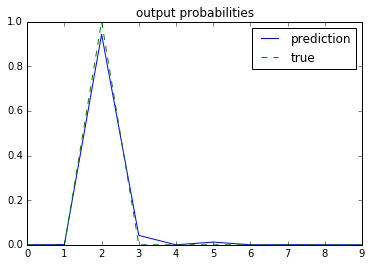

In [26]:
# Evaluate the trained model on the first example
sample_idx = 0
plt.plot(lr.forward(X_train[sample_idx]), linestyle='-', label='prediction')
plt.plot(one_hot(10, y_train[sample_idx]), linestyle='--', label='true')
plt.title('output probabilities')
plt.legend()
print(lr.predict(X_train[sample_idx]))